In [1]:
import numpy as np
from itertools import combinations
from scipy.sparse import dok_matrix
from operator import add

class SimplicialComplex:
    def __init__(self, simplices=[]):
        self.import_simplices(simplices=simplices)
        
    def import_simplices(self, simplices=[]):
        self.simplices = map(lambda simplex: tuple(sorted(simplex)), simplices)
        self.face_set = self.faces()
        
    def faces(self):
        faceset = set()
        for simplex in self.simplices:
            numnodes = len(simplex)
            for r in range(numnodes, 0, -1):
                for face in combinations(simplex, r):
                    faceset.add(face)
        return faceset
    
    def n_faces(self, n):
        return filter(lambda face: len(face)==n+1, list(self.face_set))
        
    def boundary_operator(self, i):
        source_simplices = [h for h in self.n_faces(i)]
        target_simplices = [h for h in self.n_faces(i-1)]
 
        if len(target_simplices)==0:
            S = dok_matrix((1, len(source_simplices)), dtype=np.float32)
            S[0, 0:len(source_simplices)] = 1
        else:
            source_simplices_dict = {}
            for j in range(len(source_simplices)):
                source_simplices_dict[source_simplices[j]] = j
                target_simplices_dict = {}
            for i in range(len(target_simplices)):
                target_simplices_dict[target_simplices[i]] = i
        
        S = dok_matrix((len(target_simplices), len(source_simplices)), dtype=np.float32)
        for source_simplex in source_simplices:
            for a in range(len(source_simplex)):
                target_simplex = source_simplex[:a]+source_simplex[(a+1):]
                i = target_simplices_dict[target_simplex]
                j = source_simplices_dict[source_simplex]
                S[i, j] = -1 if a%2==1 else 1 
                # S[i, j] = (-1)**a
        return S
      
    def betti_number(self, i):
        boundop_i = self.boundary_operator(i)
        boundop_ip1 = self.boundary_operator(i+1)
 
        if i==0:
          boundop_i_rank = 0
        else:
            try:
                boundop_i_rank = np.linalg.matrix_rank(boundop_i.toarray())
            except np.linalg.LinAlgError:
                boundop_i_rank = boundop_i.shape[1]
                
        try:
            boundop_ip1_rank = np.linalg.matrix_rank(boundop_ip1.toarray())
        except np.linalg.LinAlgError:
            boundop_ip1_rank = boundop_ip1.shape[1]
            
        return ((boundop_i.shape[1]-boundop_i_rank)-boundop_ip1_rank)

In [6]:
e2 = [(1,2), (2,3), (3,1), (4,5,6), (6,7), (7,4)]
sc2 = SimplicialComplex(e2)
sc2.betti_number(1)

2

C:\Users\user\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


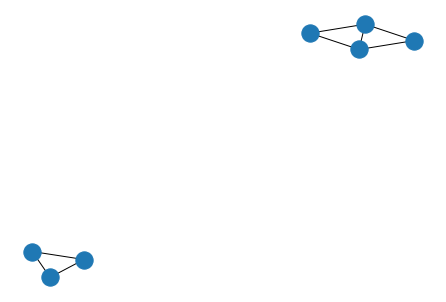

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
n2 = nx.Graph()
n2.add_edges_from(sc2.n_faces(1))
nx.draw(n2)
plt.show(nx)